In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.utils import Sequence
import numpy as np
from imutils import paths
import skimage.measure
import cv2

class DataGenerator(Sequence):
    def __init__(self, data_dir, mode='fit', batch_size=8,dim=(256, 256),scale=0.5, channels=3, shuffle=True):
        self.list_image = list(paths.list_images(data_dir))
        self.mode = mode
        self.batch_size = batch_size
        self.dim = dim
        self.scale=scale
        self.channels = channels
        self.shuffle = shuffle
        self.on_epoch_end()
   
    # phương thức này sẽ được tự đông gọi khi kết thúc 1 epoch, để đảo ngẫu nhiên lại thứ tự các ảnh khi train
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_image))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    # trả về số lượng batch
    def __len__(self):
        return int(np.floor(len(self.list_image) / self.batch_size))
    
    # trả về batch tương ứng với index
    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index+1) * self.batch_size]
        if self.mode == 'fit':
            # các train data của batch đó sẽ được lưu vào biến X
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            # nếu model đang train thì cần tạo thêm dữ liệu về ảnh gốc của batch đó
            y = np.empty((self.batch_size, *self.dim, self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                y[i]=img

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img

                # img = cv2.imread(self.list_image[ID])
                # img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                # y[i] = img
            return X,y
                
                
        # nếu model đang predict thì không cần tạo thêm dữ liệu về ảnh gốc của batch đó
        elif self.mode == 'predict':
            X = np.empty((self.batch_size, *(self.dim), self.channels))
            for i, ID in enumerate(batch_indexes):
                img = cv2.imread(self.list_image[ID])
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)

                # giảm độ phân giải hình ảnh bẳng cách dùng avg pooling theo đúng scale
                pooling_size = int(1/self.scale)
                img = skimage.measure.block_reduce(img, (pooling_size,pooling_size,1), np.mean)

                # xong lại upscale theo phương pháp bicubic interpolation
                img = cv2.resize(img, self.dim, interpolation=cv2.INTER_CUBIC)
                X[i] = img
            return X
        
        else:
            raise AttributeError("The mode should be set to either 'fit' or 'predict'.")
            

In [ ]:
train_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Train')
val_data_generator= DataGenerator('/content/drive/Shareddrives/PMAT/Datasets/HR/Valid')

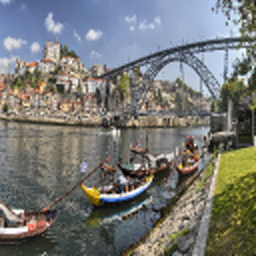

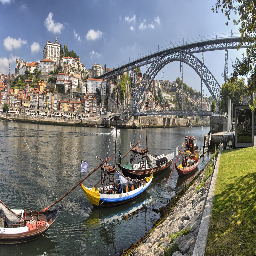

In [ ]:
from google.colab.patches import cv2_imshow

img_lr= train_data_generator[10][0][0]
img_hr=train_data_generator[10][1][0]
cv2_imshow(img_lr)
cv2_imshow(img_hr)

In [ ]:
def PSNR(y_true,y_pred):
  return tf.image.psnr(y_true, y_pred, max_val=255)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Concatenate, Add, Average, Input, Dense, Flatten, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.callbacks as callbacks



def residual_block(ip, id):
    init = ip

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_1')(ip)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_1")(x, training=True)
    x = Activation('relu', name="sr_res_activation_" + str(id) + "_1")(x)

    x = Conv2D(64, (3, 3), activation='linear', padding='same',
                      name='sr_res_conv_' + str(id) + '_2')(x)
    x = BatchNormalization( name="sr_res_batchnorm_" + str(id) + "_2")(x, training=True)

    m = Add(name="sr_res_merge_" + str(id))([x, init])

    return m

def resnet(height=256, width=256, channels=3, load_weights=False, batch_size=128):
    init= Input(shape=(height,width,channels))

    x0 = Conv2D(64, (3, 3), activation='relu', padding='same', name='sr_res_conv1')(init)

    x = residual_block(x0, 1)

    nb_residual = 5
    for i in range(nb_residual):
        x = residual_block(x, i + 2)

    x = Add()([x, x0])
    x = Conv2D(3, (3, 3), activation="linear", padding='same', name='sr_res_conv_final')(x)

    model = Model(init, x)



    return model



In [ ]:
model = resnet()

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sr_res_conv1 (Conv2D)          (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 sr_res_conv_1_1 (Conv2D)       (None, 256, 256, 64  36928       ['sr_res_conv1[0][0]']           
                                )                                                             

In [ ]:
import tensorflow as tf

def lr_scheduler(epoch, lr):
    lr=0
    if epoch <10:
        lr = 0.01
    elif epoch<30:
        lr = 0.001
    elif epoch<100:
        lr = 0.0001
    elif epoch<200:
        lr = 0.00001
    else:
        lr = 0.000001
    return lr

callbacks = [tf.keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1),
             tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Final/weights/resnet.h5',save_best_only=True,save_freq=50)
]



In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(), loss = 'mse')

In [ ]:
H=model.fit(train_data_generator,validation_data=val_data_generator,epochs=15)

Epoch 1/15
100/100 [==============================] - 218s 2s/step - loss: 1550.7894 - val_loss: 483.7519
Epoch 2/15
100/100 [==============================] - 129s 1s/step - loss: 452.9699 - val_loss: 445.3671
Epoch 3/15
100/100 [==============================] - 127s 1s/step - loss: 433.1045 - val_loss: 440.4414
Epoch 4/15
100/100 [==============================] - 127s 1s/step - loss: 422.4918 - val_loss: 418.2537
Epoch 5/15
100/100 [==============================] - 126s 1s/step - loss: 416.8582 - val_loss: 424.9332
Epoch 6/15
100/100 [==============================] - 127s 1s/step - loss: 412.6082 - val_loss: 431.8612
Epoch 7/15
100/100 [==============================] - 126s 1s/step - loss: 409.9228 - val_loss: 415.5831
Epoch 8/15
100/100 [==============================] - 126s 1s/step - loss: 407.2874 - val_loss: 413.6862
Epoch 9/15
100/100 [==============================] - 126s 1s/step - loss: 406.5848 - val_loss: 409.3212
Epoch 10/15
100/100 [==============================] -

In [ ]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('/content/drive/MyDrive/Final/weights/resnet.h5',save_best_only=True,save_freq=50)
]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),loss='mse')
H=model.fit(train_data_generator,validation_data=val_data_generator,callbacks=callbacks,epochs=30)

Epoch 1/30
100/100 [==============================] - 129s 1s/step - loss: 527.5805 - val_loss: 474.6328
Epoch 2/30
100/100 [==============================] - 127s 1s/step - loss: 445.3347 - val_loss: 443.8019
Epoch 3/30
100/100 [==============================] - 126s 1s/step - loss: 434.8531 - val_loss: 429.1748
Epoch 4/30
100/100 [==============================] - 127s 1s/step - loss: 433.4237 - val_loss: 444.4706
Epoch 5/30
100/100 [==============================] - 126s 1s/step - loss: 430.5758 - val_loss: 425.9254
Epoch 6/30
100/100 [==============================] - 126s 1s/step - loss: 422.4975 - val_loss: 422.9756
Epoch 7/30
100/100 [==============================] - 126s 1s/step - loss: 417.4161 - val_loss: 422.7079
Epoch 8/30
100/100 [==============================] - 126s 1s/step - loss: 413.6914 - val_loss: 413.6469
Epoch 9/30
100/100 [==============================] - 127s 1s/step - loss: 413.3927 - val_loss: 417.1161
Epoch 10/30
100/100 [==============================] - 

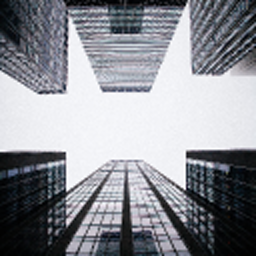

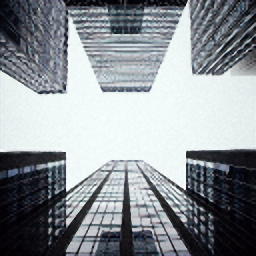

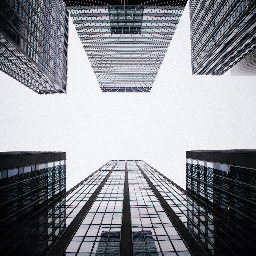

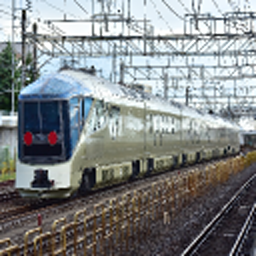

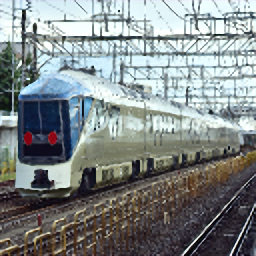

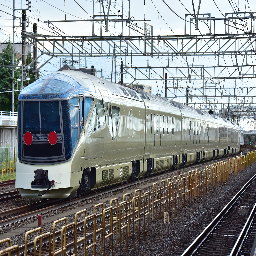

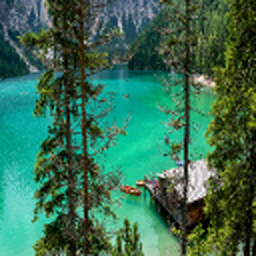

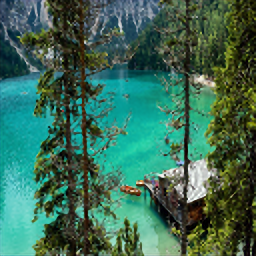

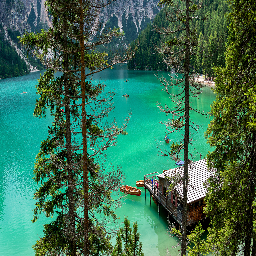

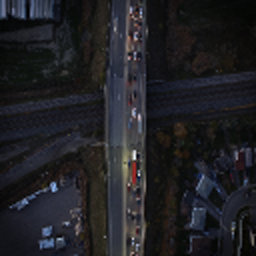

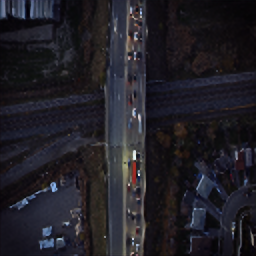

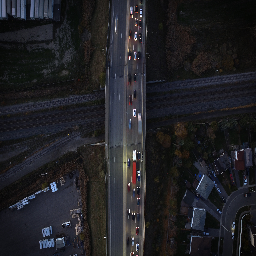

In [ ]:
model.load_weights('/content/drive/Shareddrives/PMAT/weights/resnet.h5')
img_lrs= val_data_generator[6][0]
img_hrs=val_data_generator[6][1]

outputs= model.predict(img_lrs)

for x in range(4):
  cv2_imshow(img_lrs[x])
  cv2_imshow(outputs[x])
  cv2_imshow(img_hrs[x])
